# Part 3: Deep Neural Networks and Hardware
In this notebook, we will simulate deep neural networks layers running on an
example architecture to understand how changing parameters affects energy.

The code below runs Timeloop for an example architecture using a parameterized
DNN layer. Inspect the code below, and take notes of what variables you're able
to change in the DNN layer. There are examples of how to use the code below.

100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


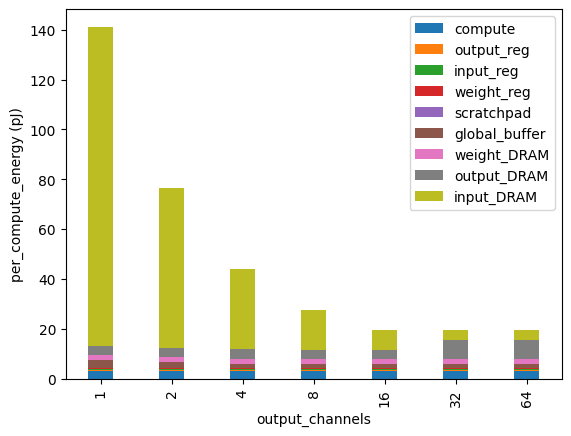

100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


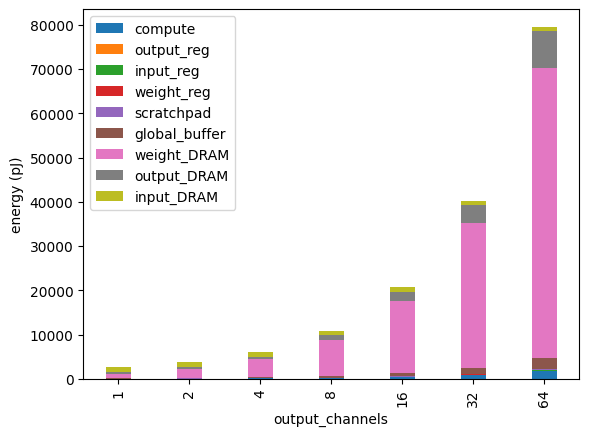

100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


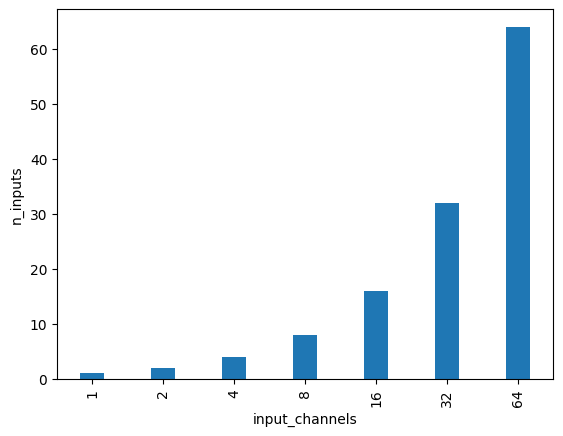

In [2]:
# Imports
from loaders import *
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytimeloop.timeloopfe.v4 as tl
import pickle
import functools
from tqdm import tqdm
from plots import *

%matplotlib inline
NUM_EPOCHS = 10

@functools.lru_cache(maxsize=None)
def run_timeloop(
    input_channels: int=8,
    output_channels: int=8,
    filter_size: int=8,
    output_size: int=8,
    stride: int=8,
):
    spec = tl.Specification.from_yaml_files(
        'arch/*.yaml',
        jinja_parse_data=dict(
        input_channels=input_channels,
        output_channels=output_channels,
        filter_size=filter_size,
        output_size=output_size,
        stride=stride,
    ))
    result = tl.call_mapper(spec, output_dir='timeloop_output')
    n_inputs = input_channels * (output_size * stride + filter_size - 1) ** 2
    n_outputs = output_channels * output_size ** 2
    n_weights = input_channels * output_channels * filter_size ** 2
    n_ops = n_inputs * n_weights + n_outputs * n_weights
    compute_intensity = n_ops / (n_inputs + n_outputs + n_weights)
    return (
        result.per_component_energy,
        result.per_compute('per_component_energy'),
        n_inputs,
        n_outputs,
        n_weights,
        n_ops,
        compute_intensity,
    )
    
def sweep(
    variable_name: str,
    values: list,
    y_value: str,
    fully_connected_layer: bool=False,
):
    results = {}
    for value in tqdm(values):
        kwargs = {variable_name: value}
        if fully_connected_layer:
            kwargs['output_size'] = 1
            kwargs['stride'] = 1
            kwargs['filter_size'] = 1
        energy, per_compute_energy, n_inputs, n_outputs, n_weights, n_ops, compute_intensity = run_timeloop(**kwargs)
        if y_value == 'per_component_energy':
            results[value] = compute_intensity
        elif y_value == 'per_compute_energy':
            results[value] = per_compute_energy * 1e12
        elif y_value == 'n_inputs':
            results[value] = n_inputs
        elif y_value == 'n_outputs':
            results[value] = n_outputs
        elif y_value == 'n_weights':
            results[value] = n_weights
        elif y_value == 'n_ops':
            results[value] = n_ops
        elif y_value == 'energy':
            results[value] = energy * 1e12
        else:
            raise ValueError(f'Unknown y_value: {y_value}')
    if 'energy' in y_value:
        y_value += ' (pJ)'
    bar_stacked(results, variable_name, y_value)

# Example 1: Sweep output channels in powers of 2 from 1 to 64. Report
# per-compute energy for each component. fully_connected_layer=False, so we're
# running a convolutional layer.
sweep(
    'output_channels',
    [1, 2, 4, 8, 16, 32, 64],
    'per_compute_energy',
    fully_connected_layer=False,
)

# Example 2: Sweep output channels in powers of 2 from 1 to 64. Report total
# energy for each component. fully_connected_layer=True, so we're running a
# fully connected layer.
sweep(
    'output_channels',
    [1, 2, 4, 8, 16, 32, 64],
    'energy',
    fully_connected_layer=True
)

# Example 3: Sweep input channels in powers of 2 from 1 to 64. Report number of
# inputs (i.e., the size of the input tensor).
sweep(
    'input_channels',
    [1, 2, 4, 8, 16, 32, 64],
    'n_inputs',
    fully_connected_layer=True
)

Now it's your turn! Answer the following questions by simulating the hardware
with differently-parameterized layers and plotting the results.

In [3]:
answer(
    question='3.1',
    subquestion='Most of the energy goes to ____.',
    answer= 'compute',
    required_type=('compute', 'data movement'),
)
answer(
    question='3.1',
    subquestion='As tensor sizes increase, compute intensity tends to ____.',
    answer= 'increase',
    required_type=('increase', 'decrease', 'stay the same'),
)

answer(
    question='3.2',
    subquestion='As tensor sizes increase, data movement energy tends to ____.',
    answer= 'increase',
    required_type=('increase', 'decrease', 'stay the same'),
)
answer(
    question='3.2',
    subquestion='As tensor sizes increase, compute energy tends to ____.',
    answer= 'increase',
    required_type=('increase', 'decrease', 'stay the same'),
)

answer( 
    question='3.3',
    subquestion='As tensor sizes increase, data movement energy per compute tends to ____.',
    answer= 'decrease',
    required_type=('increase', 'decrease', 'stay the same'),
)
answer(
    question='3.3',
    subquestion='As tensor sizes increase, compute energy per compute tends to ____.',
    answer= 'stay the same',
    required_type=('increase', 'decrease', 'stay the same'),
)

3.1: Most of the energy goes to ____.
	compute
3.1: As tensor sizes increase, compute intensity tends to ____.
	increase
3.2: As tensor sizes increase, data movement energy tends to ____.
	increase
3.2: As tensor sizes increase, compute energy tends to ____.
	increase
3.3: As tensor sizes increase, data movement energy per compute tends to ____.
	decrease
3.3: As tensor sizes increase, compute energy per compute tends to ____.
	stay the same


Now we'll answer some conceputal quesetions about the results.

In [4]:
answer(
    question='3.4',
    subquestion='Increasing compute intensity correlates with lower per-compute data movement energy due to increasing ____.',
    answer= 'data reuse',
    required_type=str,
)
answer(
    question='3.4',
    subquestion='Relative to convolution layers, fully-connected layers tend to have a ____ compute intensity for the same number of weights.',
    answer= 'lower',
    required_type=('higher', 'lower'),
)
answer(
    question='3.5',
    subquestion='For fully-connected layers with batch size one, ____ tend to be larger. (hint: try some of the layer shapes from the previous notebooks.)',
    answer= 'weights',
    required_type=('weights', 'inputs+outputs'),
)
answer(
    question='3.5',
    subquestion='For convolutional layers with batch size one, ____ tend to be larger. (hint: try some of the layer shapes from the previous notebooks.)',
    answer= 'inputs+outputs',
    required_type=('weights', 'inputs+outputs'),
)

3.4: Increasing compute intensity correlates with lower per-compute data movement energy due to increasing ____.
	data reuse
3.4: Relative to convolution layers, fully-connected layers tend to have a ____ compute intensity for the same number of weights.
	lower
3.5: For fully-connected layers with batch size one, ____ tend to be larger. (hint: try some of the layer shapes from the previous notebooks.)
	weights
3.5: For convolutional layers with batch size one, ____ tend to be larger. (hint: try some of the layer shapes from the previous notebooks.)
	inputs+outputs
